**Feature Selection**
This code below uses all other columns from the excel sheet except the heart rate column as features or inputs into the machine learning model. 

**Feature Engineering**
No explicit feature engineering to create new features using existing data is done due to a limited availability of features. 

**Data Normalization:**
Does not include data normalization or standardization steps. Machine learning models, especially neural networks like LSTM, often benefit from having input features on a similar scale.

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
import pandas as pd

# File path to the Excel data
file_path = 'data-for-predicting-hr.xlsx'

# Dictionary to store cleaned DataFrames for each sheet
cleaned_dfs = {}

# Get the list of sheet names in the Excel file
with pd.ExcelFile(file_path) as xls:
    sheet_names = xls.sheet_names

# Iterate through each sheet and remove rows with missing values in the 'hr_mean' column
for sheet_name in sheet_names:
    # Load the sheet into a DataFrame
    sheet_df = pd.read_excel(file_path, sheet_name=sheet_name)

    # Remove rows where 'hr_mean' is NaN
    cleaned_df = sheet_df.dropna(subset=['hr_mean'])

    # Store the cleaned DataFrame
    cleaned_dfs[sheet_name] = cleaned_df


# Function to train and evaluate ARIMA model
def train_and_evaluate_arima(y_train, y_test):
    model = ARIMA(y_train, order=(5,1,0))
    model_fit = model.fit()
    forecast_output = model_fit.forecast(steps=len(y_test))
    y_pred = forecast_output.values  # Use the Pandas Series values
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2


# Function to train and evaluate LSTM model
def train_and_evaluate_lstm(X_train, X_test, y_train, y_test):
    X_train_reshaped = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
    X_test_reshaped = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=72, verbose=0)
    y_pred = model.predict(X_test_reshaped)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2


# Loop through the cleaned DataFrames for each sheet
    # Inside your loop through cleaned DataFrames
for sheet_name, cleaned_df in cleaned_dfs.items():
    print(f"Processing sheet: {sheet_name}")

    # Filter to only numeric columns to avoid TensorFlow error
    X = cleaned_df.select_dtypes(include=[np.number]).drop(columns=['hr_mean'])
    y = cleaned_df['hr_mean']

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize models
    # Initialize and fit models
    linear_model = LinearRegression().fit(X_train, y_train)
    rf_model = RandomForestRegressor(random_state=42).fit(X_train, y_train)
    gb_model = GradientBoostingRegressor(random_state=42).fit(X_train, y_train)

    # Make predictions
    linear_pred = linear_model.predict(X_test)
    rf_pred = rf_model.predict(X_test)
    gb_pred = gb_model.predict(X_test)

    # Evaluate models
    linear_mae = mean_absolute_error(y_test, linear_pred)
    linear_mse = mean_squared_error(y_test, linear_pred)
    linear_r2 = r2_score(y_test, linear_pred)

    rf_mae = mean_absolute_error(y_test, rf_pred)
    rf_mse = mean_squared_error(y_test, rf_pred)
    rf_r2 = r2_score(y_test, rf_pred)

    gb_mae = mean_absolute_error(y_test, gb_pred)
    gb_mse = mean_squared_error(y_test, gb_pred)
    gb_r2 = r2_score(y_test, gb_pred)


    # Train and evaluate ARIMA model
    arima_mae, arima_mse, arima_r2 = train_and_evaluate_arima(y_train.reset_index(drop=True),
                                                              y_test.reset_index(drop=True))

    # Train and evaluate LSTM model
    lstm_mae, lstm_mse, lstm_r2 = train_and_evaluate_lstm(X_train, X_test, y_train, y_test)

    # Compile all results
    results = {
        'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'ARIMA', 'LSTM'],
        'MAE': [linear_mae, rf_mae, gb_mae, arima_mae, lstm_mae],
        'MSE': [linear_mse, rf_mse, gb_mse, arima_mse, lstm_mse],
        'R2': [linear_r2, rf_r2, gb_r2, arima_r2, lstm_r2]
    }

    results_df = pd.DataFrame(results)
    print("Results for sheet:", sheet_name)
    print(results_df)
    print("\n" + "=" * 50 + "\n")

Processing sheet: id003
1/1 [==============================] - 0s 142ms/step
Results for sheet: id003
               Model        MAE          MSE         R2
0  Linear Regression   7.688337    91.816611  -0.120133
1      Random Forest   7.437256    80.781135   0.014496
2  Gradient Boosting   7.860456    87.318852  -0.065262
3              ARIMA  12.032647   203.064602  -1.477323
4               LSTM  87.886184  7805.950777 -94.230095


Processing sheet: id004
1/1 [==============================] - 0s 133ms/step
Results for sheet: id004
               Model        MAE          MSE         R2
0  Linear Regression  15.555211   390.978698  -0.270029
1      Random Forest  13.876229   295.041642   0.041607
2  Gradient Boosting  15.599594   346.330308  -0.124996
3              ARIMA  15.259500   317.444749  -0.031166
4               LSTM  85.650224  7643.953775 -23.830101


Processing sheet: id007
1/1 [==============================] - 0s 128ms/step
Results for sheet: id007
               Mod

To incorporate feature selection based on cumulative importance in my existing models, you can use a technique that ranks features by their importance (usually given by tree-based models like Random Forest) and retains only the top features that contribute to a certain percentage (e.g., 95%) of the cumulative importance.

Here's a modified version of your code to include this feature selection process:

Calculate Feature Importance: Use the Random Forest model to calculate feature importances.
Select Top Features: Determine the top features that contribute to the 95% cumulative importance.
Train Models with Selected Features: Train all models (Linear Regression, Random Forest, Gradient Boosting, ARIMA, LSTM) using only the selected features.

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
import pandas as pd

# File path to the Excel data
file_path = 'data-for-predicting-hr.xlsx'

# Dictionary to store cleaned DataFrames for each sheet
cleaned_dfs = {}

# Get the list of sheet names in the Excel file
with pd.ExcelFile(file_path) as xls:
    sheet_names = xls.sheet_names

# Iterate through each sheet and remove rows with missing values in the 'hr_mean' column
for sheet_name in sheet_names:
    # Load the sheet into a DataFrame
    sheet_df = pd.read_excel(file_path, sheet_name=sheet_name)

    # Remove rows where 'hr_mean' is NaN
    cleaned_df = sheet_df.dropna(subset=['hr_mean'])

    # Store the cleaned DataFrame
    cleaned_dfs[sheet_name] = cleaned_df

# Function to select top cumulative features
def select_top_features(X_train, model, cumulative_importance=0.95):
    # Calculate feature importances
    importances = model.feature_importances_
    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    # Calculate cumulative importance
    sorted_importances = importances[indices]
    cumulative_importances = np.cumsum(sorted_importances)
    # Determine number of features needed for cumulative importance
    n_features = np.where(cumulative_importances > cumulative_importance)[0][0] + 1
    # Get the top features
    top_features = X_train.columns[indices[:n_features]]
    return top_features

# Function to train and evaluate ARIMA model
def train_and_evaluate_arima(y_train, y_test):
    model = ARIMA(y_train, order=(5,1,0))
    model_fit = model.fit()
    forecast_output = model_fit.forecast(steps=len(y_test))
    y_pred = forecast_output.values  # Use the Pandas Series values
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2

# Function to train and evaluate LSTM model
def train_and_evaluate_lstm(X_train, X_test, y_train, y_test):
    X_train_reshaped = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
    X_test_reshaped = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=72, verbose=0)
    y_pred = model.predict(X_test_reshaped)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2

# Loop through the cleaned DataFrames for each sheet
for sheet_name, cleaned_df in cleaned_dfs.items():
    print(f"Processing sheet: {sheet_name}")

    # Filter to only numeric columns to avoid TensorFlow error
    X = cleaned_df.select_dtypes(include=[np.number]).drop(columns=['hr_mean'])
    y = cleaned_df['hr_mean']

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Random Forest to get feature importances
    rf_model = RandomForestRegressor(random_state=42).fit(X_train, y_train)
    # Select top features
    top_features = select_top_features(X_train, rf_model)

    # Filter X_train and X_test to include only top features
    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]

    # Re-train models with selected features
    linear_model = LinearRegression().fit(X_train_selected, y_train)
    rf_model_selected = RandomForestRegressor(random_state=42).fit(X_train_selected, y_train)
    gb_model_selected = GradientBoostingRegressor(random_state=42).fit(X_train_selected, y_train)

    
    # Make predictions with selected features
    linear_pred = linear_model.predict(X_test_selected)
    rf_pred = rf_model_selected.predict(X_test_selected)
    gb_pred = gb_model_selected.predict(X_test_selected)

    # Evaluate models with selected features
    linear_mae = mean_absolute_error(y_test, linear_pred)
    linear_mse = mean_squared_error(y_test, linear_pred)
    linear_r2 = r2_score(y_test, linear_pred)

    rf_mae = mean_absolute_error(y_test, rf_pred)
    rf_mse = mean_squared_error(y_test, rf_pred)
    rf_r2 = r2_score(y_test, rf_pred)

    gb_mae = mean_absolute_error(y_test, gb_pred)
    gb_mse = mean_squared_error(y_test, gb_pred)
    gb_r2 = r2_score(y_test, gb_pred)

    # Train and evaluate ARIMA model (on the original dataset)
    arima_mae, arima_mse, arima_r2 = train_and_evaluate_arima(y_train.reset_index(drop=True),
                                                              y_test.reset_index(drop=True))

    # Train and evaluate LSTM model (on the selected features)
    lstm_mae, lstm_mse, lstm_r2 = train_and_evaluate_lstm(X_train_selected, X_test_selected, y_train, y_test)

    # Compile all results
    results = {
        'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'ARIMA', 'LSTM'],
        'MAE': [linear_mae, rf_mae, gb_mae, arima_mae, lstm_mae],
        'MSE': [linear_mse, rf_mse, gb_mse, arima_mse, lstm_mse],
        'R2': [linear_r2, rf_r2, gb_r2, arima_r2, lstm_r2]
    }

    results_df = pd.DataFrame(results)
    print("Results for sheet:", sheet_name)
    print(results_df)
    print("\n" + "=" * 50 + "\n")
    


Processing sheet: id003
1/1 [==============================] - 0s 134ms/step
Results for sheet: id003
               Model        MAE          MSE         R2
0  Linear Regression   7.392444    76.724159   0.063990
1      Random Forest   7.461877    80.715689   0.015294
2  Gradient Boosting   7.251617    77.485200   0.054705
3              ARIMA  12.032647   203.064602  -1.477323
4               LSTM  88.074238  7839.363440 -94.637719


Processing sheet: id004
1/1 [==============================] - 0s 140ms/step
Results for sheet: id004
               Model        MAE          MSE         R2
0  Linear Regression  14.126077   291.089100   0.054446
1      Random Forest  13.785779   292.729228   0.049118
2  Gradient Boosting  15.286684   345.347849  -0.121805
3              ARIMA  15.259500   317.444749  -0.031166
4               LSTM  84.641728  7472.072370 -23.271773


Processing sheet: id007
1/1 [==============================] - 0s 135ms/step
Results for sheet: id007
               Mod

Numerical Analysis:
Mean Absolute Error (MAE): Lower values are better. It measures the average magnitude of errors in a set of predictions, without considering their direction.
Mean Squared Error (MSE): Lower values are better. It squares the errors before averaging them, which penalizes larger errors more than the MAE does.
R-squared (R2): Higher values are better, ideally closer to 1. It represents the proportion of variance for the dependent variable that's explained by the independent variables.

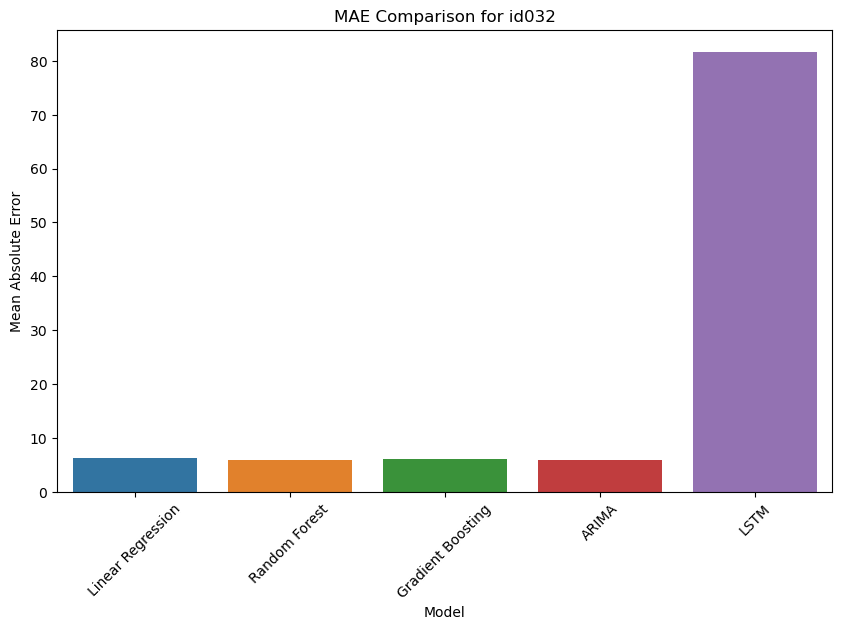

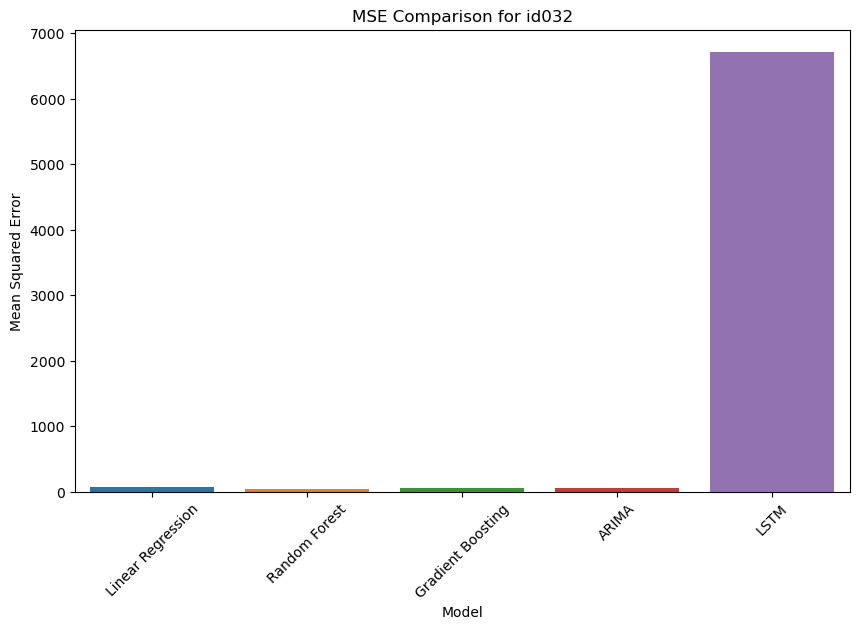

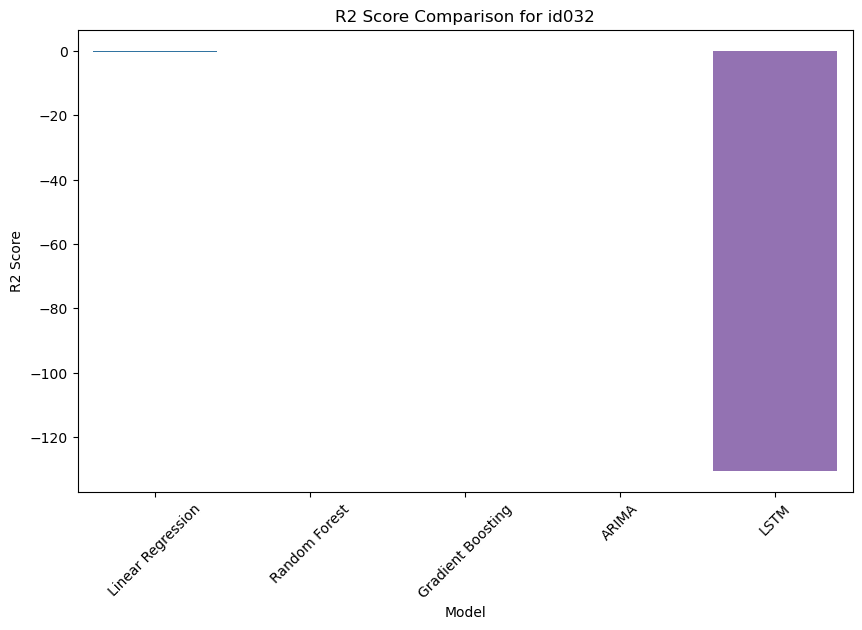

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a dictionary 'results_per_sheet' that stores the results DataFrames for each sheet
results_per_sheet = {}  # Initialize an empty dictionary

# Include this inside your loop, where you print the results for each sheet
results_per_sheet[sheet_name] = results_df  # Store the results DataFrame for each sheet

# After processing all sheets
for sheet_name, results_df in results_per_sheet.items():
    # Plotting MAE for each model
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='MAE', data=results_df)
    plt.title(f'MAE Comparison for {sheet_name}')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.show()

    # Plotting MSE for each model
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='MSE', data=results_df)
    plt.title(f'MSE Comparison for {sheet_name}')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.show()

    # Plotting R2 for each model
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='R2', data=results_df)
    plt.title(f'R2 Score Comparison for {sheet_name}')
    plt.ylabel('R2 Score')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.show()
